In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, Sed, LightCurve, SNSurvey, SkyObject
from astropy.table import Table

import pickle

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [4]:
errf_dict = {band:np.array([]) for band in bandpasses.names}
redshifts = []
with open('plasticc_data/SNIa_SkyObjects.pkl', 'rb') as sne:
    for sn in pickle.load(sne):
        
        redshifts.append(sn.specz)
        
        pmin, pmax = -20, 80
        phase = sn.photometry['mjd'] - sn.t0
        sn.photometry = sn.photometry[(phase >= pmin) & (phase <= pmax)]
        
        ferr_cut = 0.05
        sn.photometry = sn.photometry[np.abs(sn.photometry['flux_err']/sn.photometry['flux']) <= ferr_cut]  
        
        for name in bandpasses.names: 
            idx = np.where(sn.photometry['filter'] == name)[0]
            errf = np.abs(sn.photometry['flux_err'][idx]/sn.photometry['flux'][idx])
            errf_dict[name] = np.concatenate((errf_dict[name], errf))

In [5]:
biases = np.array([0, 0, -0.01,    0,    0, 0])

In [6]:
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 11100, 10)
lc = LightCurve(time, wavelen)
lc.from_model(model)

SED = lc.sed_slice(0)
objects = []

np.random.seed(11)

redshift_sample = np.random.choice(redshifts, 300, replace=False)

for z in redshift_sample:
    
    obj = SkyObject()
    obj.specz = z
    SED.redshift(z)
    
    obj.photometry = Table()
    obj.photometry['filter'] = bandpasses.names
    fluxes = SED.fluxes(bandpasses) * (1 + biases)
    errf = np.array([np.random.choice(dist,1)[0] for dist in errf_dict.values()])
    fluxes = np.random.normal(fluxes, errf * fluxes)
    flux_err = np.clip(errf * fluxes, 1e-6, None)
    obj.photometry['flux'] = fluxes
    obj.photometry['flux_err'] = flux_err
    
    objects.append(obj)
    
SED.redshift(0)

Now train an SED

In [7]:
sed = Sed()
sed.wavelen = np.arange(1000, 11100, 100)
sed.null()

%time model, fit_bias = sed.train(objects, bandpasses, fit_bias=True, return_flag=True, verbose=True, Ncpus=4)

alpha = 1.0
N_EDB = 44
Max width = 500
N_split = 4
 
beta = 0.0151
Biases:
lsstu: -0.0000
lsstg:  0.0000
lsstr: -0.0048
lssti:  0.0000
lsstz:  0.0000
lssty: -0.0000
 
 Consider raising the range of alphas tested.
 Consider raising the range of N_EDBs tested.
 Consider lowering the range of Max widths tested.
CPU times: user 16.3 s, sys: 4.99 s, total: 21.3 s
Wall time: 1min 23s


In [8]:
fit_bias

array([-0.        ,  0.        , -0.00477379,  0.        ,  0.        ,
       -0.        ])

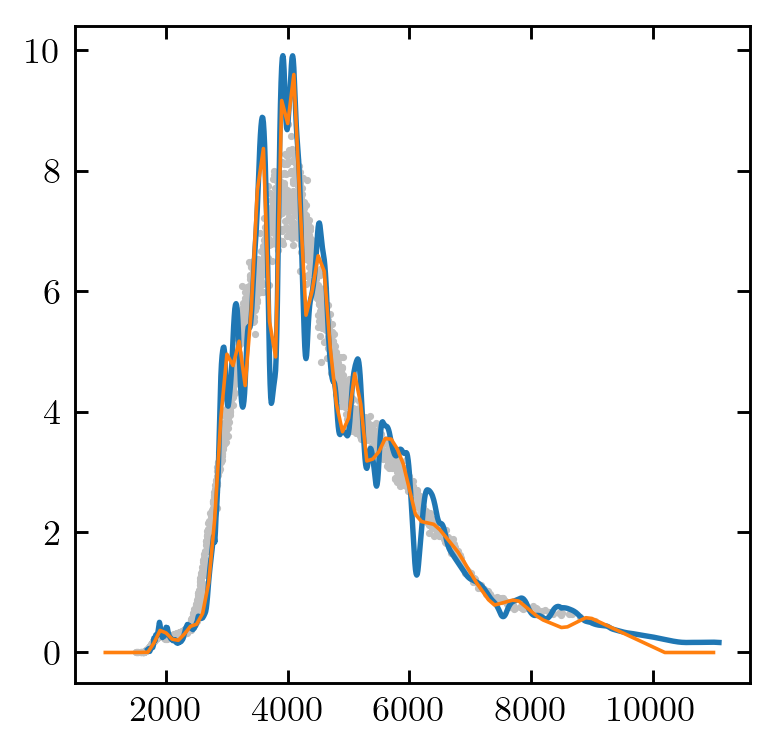

In [9]:
plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

for obj in objects:
    wavelen = bandpasses.mean_wavelens(obj.photometry['filter'])/(1 + obj.specz)
    plt.scatter(wavelen, obj.photometry['flux'], c='silver')

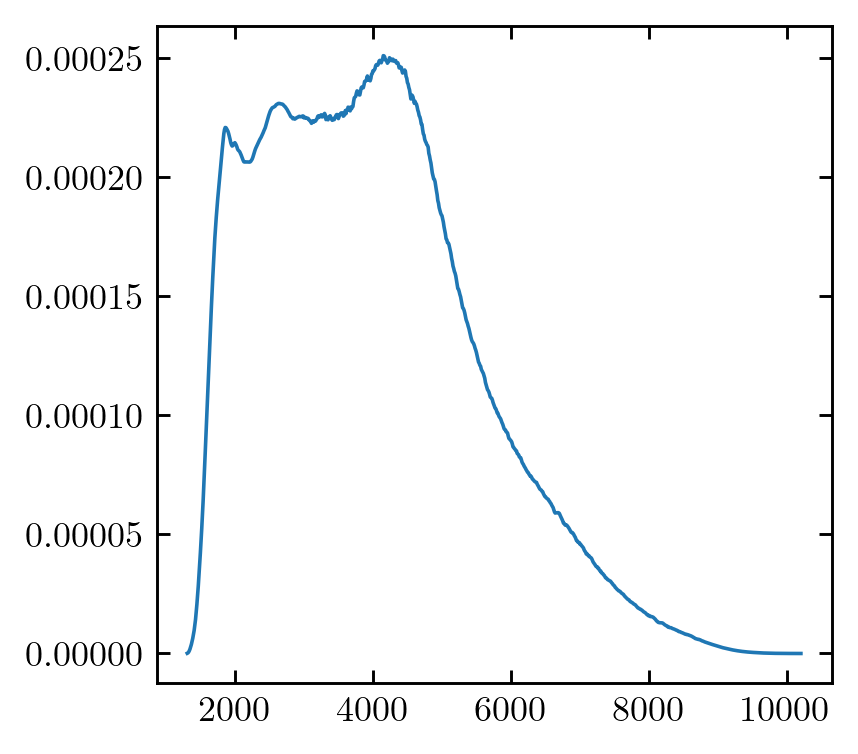

In [10]:
plt.plot(model.initbins,model.infoDen_)
plt.show()

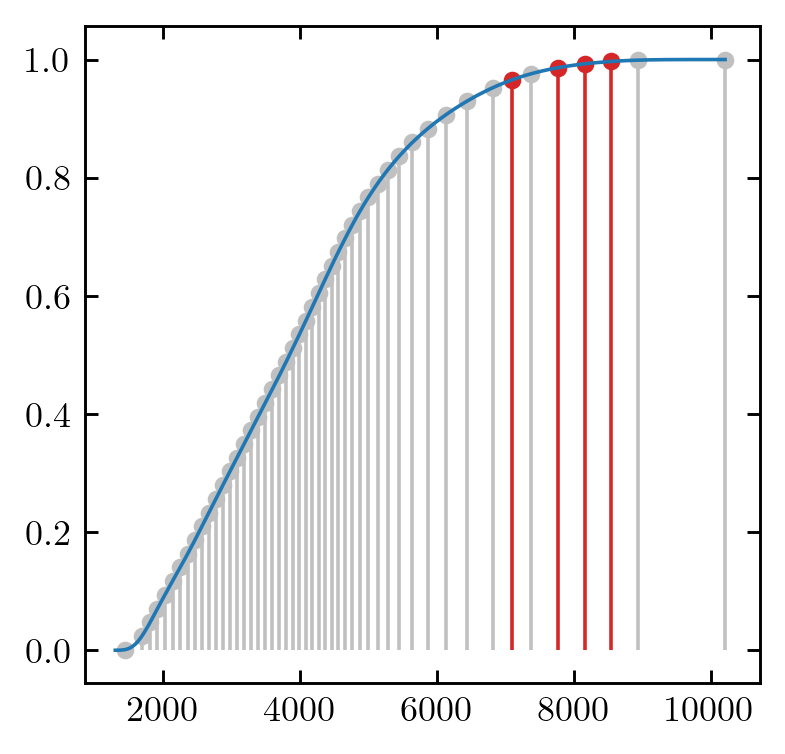

In [28]:
plt.plot(model.initbins, model.cumInfo_)
color_key = np.isclose(np.diff(model.allbins_, n=2), 0)
for i,w in enumerate(model.allbins_):
    
    if i == 0 or i == len(model.allbins_)-1:
        c = 'silver'
    else:
        key = color_key[i-1]
        c = 'C3' if key == True else 'silver'
    
    I = np.interp(w, model.initbins, model.cumInfo_)
    plt.vlines(w, 0, I, color=c)
    plt.scatter(w, I, c=c, s=15)
    
plt.vlines(model.initbins[-1], 0, 1, color='silver')
plt.scatter(model.initbins[-1], 1, c='silver', s=15)